In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Honda = data.DataReader("HMC", data_source="yahoo", start = "1980-03-01", end = "2019-06-01")
Honda.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-03-17,0.909375,0.893750,0.893750,0.893750,26000.0,0.345008
1980-03-18,0.909375,0.909375,0.909375,0.909375,2000.0,0.351039
1980-03-19,0.898435,0.898435,0.898435,0.898435,2000.0,0.346816
1980-03-20,0.898435,0.898435,0.898435,0.898435,0.0,0.346816
1980-03-21,0.898435,0.898435,0.898435,0.898435,2000.0,0.346816


In [3]:
Honda.shape

(9883, 6)

In [4]:
Honda_train = Honda.iloc[:9700, :]
Honda_train.shape

(9700, 6)

In [5]:
Honda_test = Honda.iloc[9700:, :]
Honda_test.shape

(183, 6)

In [6]:
training_set = Honda.iloc[:9700, 2:3].values
training_set

array([[  0.89375001],
       [  0.90937501],
       [  0.898435  ],
       ..., 
       [ 30.52000046],
       [ 30.5       ],
       [ 30.12999916]])

In [7]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 9699):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set using Keras Callbacks
es = EarlyStopping(monitor='loss', mode='min', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
history = regressor.fit(X_train, y_train, shuffle=True, epochs = 100, callbacks=[es, rlr,mcp, tb],batch_size = 128)

Using TensorFlow backend.


Epoch 1/100
9639/9639 [==============================] - 128s 13ms/step - loss: 0.0179

Epoch 00001: loss improved from inf to 0.01789, saving model to weights.h5
Epoch 2/100
9639/9639 [==============================] - 121s 13ms/step - loss: 0.0030

Epoch 00002: loss improved from 0.01789 to 0.00298, saving model to weights.h5
Epoch 3/100
9639/9639 [==============================] - 124s 13ms/step - loss: 0.0027

Epoch 00003: loss improved from 0.00298 to 0.00268, saving model to weights.h5
Epoch 4/100
9639/9639 [==============================] - 122s 13ms/step - loss: 0.0024

Epoch 00004: loss improved from 0.00268 to 0.00243, saving model to weights.h5
Epoch 5/100
9639/9639 [==============================] - 119s 12ms/step - loss: 0.0022

Epoch 00005: loss improved from 0.00243 to 0.00224, saving model to weights.h5
Epoch 6/100
9639/9639 [==============================] - 118s 12ms/step - loss: 0.0021

Epoch 00006: loss improved from 0.00224 to 0.00212, saving model to weights.h5
Ep

In [9]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock price until 2019
real_stock_price = Honda_test.iloc[:, 2:3].values

In [10]:
# Getting the predicted stock price until 2019
Honda_total = pd.concat((Honda_train['Close'], Honda_test['Close']), axis = 0)
inputs = Honda_total[len(Honda_total) - len(Honda_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 243):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

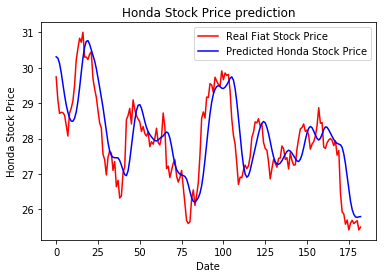

In [11]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Fiat Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Honda Stock Price')
plt.title('Honda Stock Price prediction')
plt.xlabel('Date')
plt.ylabel('Honda Stock Price')
plt.legend()
plt.show()

In [12]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

0.7455506685943594

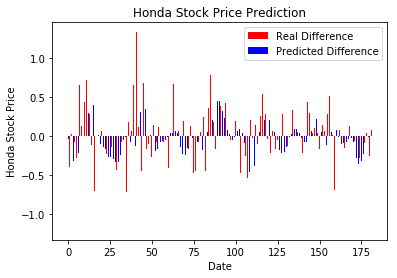

In [13]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Honda Stock Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Honda Stock Price')
ax.legend()
plt.show()

In [15]:
min_val=min(real_stock_price)
max_val=max(real_stock_price)
print ("relative error: ", rmse/(max_val-min_val))

relative error:  [ 0.13361123]
